In [32]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [39]:
#%%capture

%run examples/scenario_1.py --sil

INFO:     Started server process [13936]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)
  0%|          | 0/172800 [00:00<?, ?steps/s]Exception in thread Thread-35 (update_power_model):
Traceback (most recent call last):
  File "c:\Users\kilian\anaconda3\envs\Synergy\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\kilian\anaconda3\envs\Synergy\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "d:\TU-Berlin\Arbeit\vessim\vessim\cosim\energy_system_interface.py", line 105, in update_power_model
    http_client.put("/power_mode", {"power_mode": node.power_mode})
  File "d:\TU-Berlin\Arbeit\vessim\vessim\sil\http_client.py", line 58, in put
    data=json.dumps(data),
         ^^^^^^^^^^^^^^^^
  File "c:\Users\kilian\anaconda3\envs\Synergy\Lib\json\__init__.py", line 231, in dumps
    return _default_encoder.enc

AttributeError: 'tuple' object has no attribute 'tb_frame'

In [ ]:
# Get data of simulation
with open ("data.csv", "r") as f:
    simulation_data = pd.read_csv(f)

In [ ]:
simulation_data["p_solar"] = simulation_data["p_solar"] * 0.4*0.5 * .17  # W/m^2 * m^2 = W

NameError: name 'emissions' is not defined

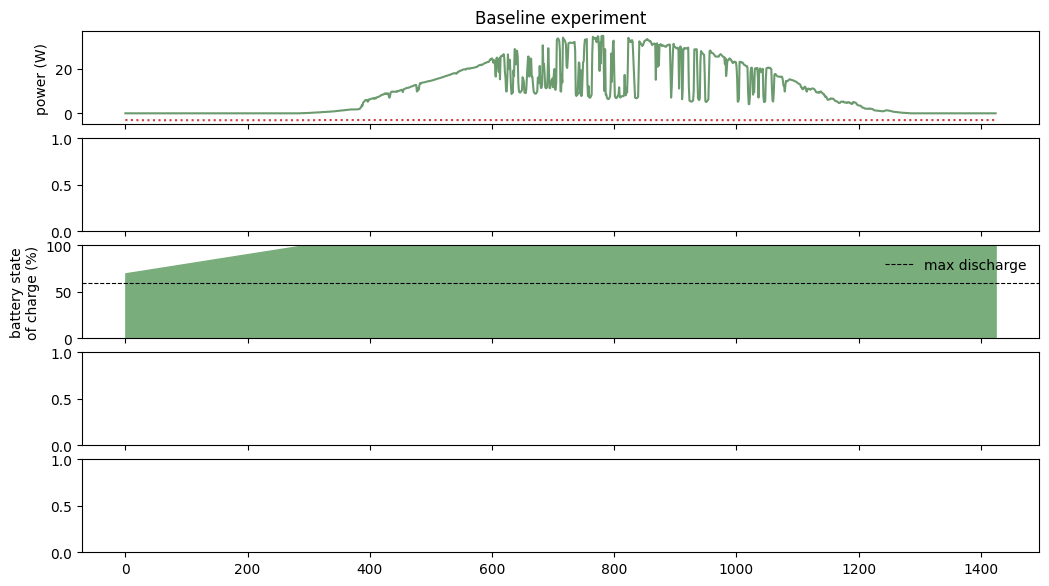

In [ ]:
RED = "#D65D62"
BATTERY_COLOR = "#79ae7c"
GREEN = BATTERY_COLOR  # "#8BC34A"

def plot_evaluation(measurements_df, axs, title: str, left: bool):
    axs[0].set_title(title)

    measurements_df["p_solar"].plot(ax=axs[0], color="#6b9a6e", label="production")
    (measurements_df["p_computing_system"] * (-1)).plot(ax=axs[0], color="#ce3d43", label="physical node", linestyle=":")
    axs[0].set_ylabel("power (W)")
    #h, l = axs[0].get_legend_handles_labels()
    #axs[0].legend([h[2], h[1], h[0]], [l[2], l[1], l[0]], frameon=False, ncol=2, columnspacing=0.9)
    #ü = h[2]

    #x = measurements_df["delta_power"]
    #x.plot(ax=axs[1], alpha=0)  # this call improves performance
    #axs[1].fill_between(x.index, 0, x.values, where=x.values>0, color=GREEN)
    #axs[1].fill_between(x.index, 0, x.values, where=x.values<0, color=RED)
    #axs[1].set_ylabel("power\ndelta (W)")

    x = measurements_df["battery_soc"]
    x.plot(ax=axs[2], alpha=0)  # performance
    axs[2].fill_between(x.index, 0, x.values * 100, color=BATTERY_COLOR)
    axs[2].set_ylim(0, 100)
    axs[2].set_ylabel("battery state\nof charge (%)")
    if left:
        axs[2].axhline(60, linestyle="--", linewidth=.8, color="black", label="max discharge")
    else:
        X1 = .26
        X2 = .52
        X3 = .73
        axs[2].axhline(30, xmin=0, xmax=X1, linestyle="--", linewidth=.8, color="black", label="max discharge")
        axs[2].axhline(60, xmin=X1, xmax=X2, linestyle="--", linewidth=.8, color="black")
        axs[2].axhline(30, xmin=X2, xmax=X3, linestyle="--", linewidth=.8, color="black")
        axs[2].axhline(60, xmin=X3, xmax=1, linestyle="--", linewidth=.8, color="black")
        axs[2].axvline(X1, ymin=30, ymax=60, linestyle="--", linewidth=.8, color="black")
        axs[2].axvline(X2, ymin=30, ymax=60, linestyle="--", linewidth=.8, color="black")
        axs[2].axvline(X3, ymin=30, ymax=60, linestyle="--", linewidth=.8, color="black")

    h, l = axs[2].get_legend_handles_labels()
    axs[2].legend(h[1:], l[1:], frameon=False)

    #grid = -measurements_df["excess_power"].groupby(pd.Grouper(freq='5min')).mean()
    #grid[grid < 0] = 0
    #grid.plot(ax=axs[3], alpha=0)  # performance
    #axs[3].fill_between(grid.index, 0, grid.values, color=RED)
    #axs[3].set_ylabel("grid power\nusage (W)")

    #ax3_twin = axs[3].twinx()
    #carbon.plot(ax=ax3_twin, color="#333", linewidth=.8)
    #ax3_twin.set_ylim(0, 350)
    #if not left:
    #    ax3_twin.set_ylabel("carbon intensity\n(gCO2/kWh)")
    #    ax3_twin.set_yticks([0, 100, 200, 300])
    #else:
    #    ax3_twin.set_yticks([])

    #h_, _ = ax3_twin.get_legend_handles_labels()
    #if left:
    #    x = 0.35
    #else:
    #    x = 0.45
    #axs[3].legend([ü] + h_, ["grid power usage", "carbon intensity"], frameon=False, loc='upper center', bbox_to_anchor=(x, 0.63))

    #grid = -measurements_df["excess_power"]
    #grid[grid < 0] = 0
    #emissions = grid * carbon  # 60 Ws * gCO2/kWh  //  gCO2/60000 // kgCO2/60000/1000
    #emissions /= 60000
    #emissions.cumsum().plot(ax=axs[4], color="#555", linewidth=.8)
    #axs[4].fill_between(emissions.index, emissions.cumsum().values, color="#ddd")
    #axs[4].set_ylabel("accumulated\nemissions (gCO2)")
    #axs[4].set_ylim(0, 43)
    #axs[4].set_xlabel("")
    #axs[4].set_xticks("2020")
    #print(f"Carbon Emissions: {emissions.sum():.2f} gCO2; Grid energy: {grid.sum() * 60 / 3600:.2f} Wh")
    return emissions, grid

fig, axs = plt.subplots(ncols=1, nrows=5, sharex="col", sharey="row", figsize=(10,5.5))
fig.tight_layout(pad=0)
emissions, grid = plot_evaluation(simulation_data, axs, title="Baseline experiment", left=True)
fig.align_ylabels()